# 1. Heatmap only

In [1]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/heatmap only/checkpoint5.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
GPU = 7

from models.siamese import SiameseNet
from models.HCNN import HCNN
from collections import OrderedDict
model = HCNN()

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # add `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.to(GPU)
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_heatmaps = batch['left_heatmap']
        right_heatmaps = batch['right_heatmap']
        labels = batch['label']
        
        left_tensor = left_heatmaps.unsqueeze(1).to(GPU)
        right_tensor = right_heatmaps.unsqueeze(1).to(GPU)
        label_tensor = labels.float().unsqueeze(1).to(GPU)
        
        outputs = model(left_tensor, right_tensor)
        # loss = criterion(outputs, label_tensor)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        # TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        # FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        # FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        # TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        # acc = (TP + TN) / len(image_paths)
        # prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        # rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        # f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        # print(f'Batch prec:{prec}')
        # print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], probs[i].item(), preds[i].item(), labels[i].item()])             

/work/adapting-CLIP-VGPs


  0%|          | 0/813 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 813/813 [07:33<00:00,  1.79it/s]


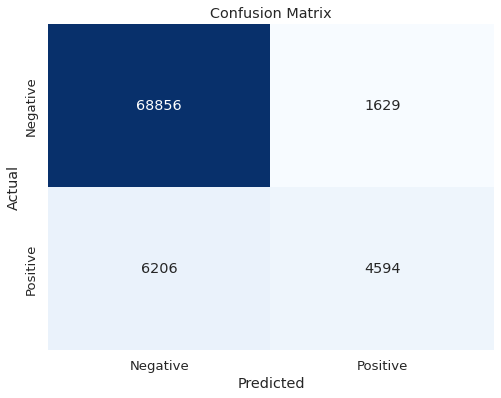

Accuracy: 0.9036107522913207
Precision: 0.7382291499276876
Recall: 0.42537037037037034
F1 Score: 0.5397403512894319


In [2]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [7]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/heatmap only/06_checkpoint5.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
GPU = 0

from models.text_heatmap_sigmoid import TextHeatmapSigmoidClassifier
from collections import OrderedDict
model = TextHeatmapSigmoidClassifier(heatmap_only=True, gating=True, use_dropout=True)

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # remove `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.to(GPU)
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_text_ft = batch['left_text_emb']
        right_text_ft = batch['right_text_emb']
        left_heatmaps = batch['left_heatmap']
        right_heatmaps = batch['right_heatmap']
        labels = batch['label']
        
        left_heatmaps = left_heatmaps.unsqueeze(1).to(GPU)
        right_heatmaps = right_heatmaps.unsqueeze(1).to(GPU)
        left_text_ft = left_text_ft.squeeze(1).to(GPU)
        right_text_ft = right_text_ft.squeeze(1).to(GPU)
        label_tensor = labels.float().unsqueeze(1).to(GPU)
        
        outputs = model(left_heatmaps, right_heatmaps, left_text_ft, right_text_ft)
        # loss = criterion(outputs, label_tensor)
        preds = (outputs > 0.5).float()

        # TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        # FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        # FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        # TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        # acc = (TP + TN) / len(image_paths)
        # prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        # rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        # f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        # print(f'Batch prec:{prec}')
        # print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], probs[i].item(), preds[i].item(), labels[i].item()])             

/work/adapting-CLIP-VGPs


  0%|          | 0/813 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 813/813 [05:26<00:00,  2.49it/s]


In [33]:
checkpoint['optimizer_state_dict']['param_groups'][0]['lr']

0.001

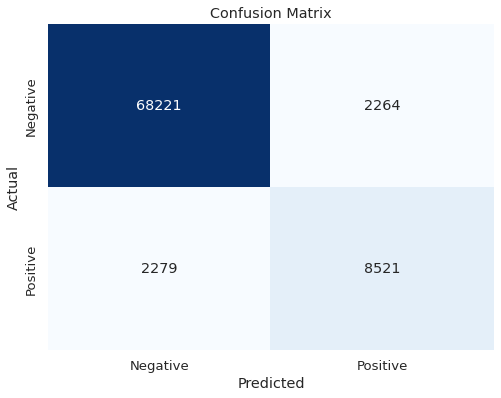

Accuracy: 0.944110229439626
Precision: 0.7900788131664349
Recall: 0.7889814814814815
F1 Score: 0.7895297660412324


In [12]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [24]:
result_data = pd.DataFrame(test_results)
adjusted_pred = result_data[2]>0.54
adjusted_pred

0         True
1        False
2        False
3        False
4        False
         ...  
81280    False
81281     True
81282    False
81283    False
81284    False
Name: 2, Length: 81285, dtype: bool

In [35]:
import numpy as np
def find_best_f1(scores, gt):
    step = 0.001
    cur_best_f1 = 0
    cur_prec = 0
    cur_rec = 0
    cur_best_thres = 0
    for thres in np.arange(cur_best_thres, 1, step):
        new_pred = scores > thres
        f1 = f1_score(gt, new_pred)

        if f1 > cur_best_f1:
            cur_best_thres = thres
            cur_best_f1 = f1
            cur_prec = precision_score(gt, new_pred)
            cur_rec = recall_score(gt, new_pred)
            
    return cur_best_thres, cur_best_f1, cur_prec, cur_rec

find_best_f1(result_data[2], gt)

(0.519, 0.38842916250535026, 0.3159085634718032, 0.5041666666666667)

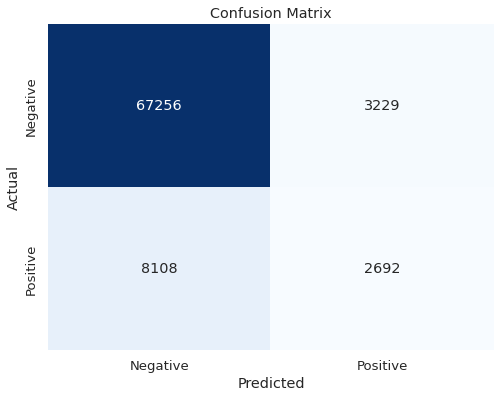

Accuracy: 0.8605277726517808
Precision: 0.45465293024826886
Recall: 0.24925925925925926
F1 Score: 0.3219903115842354


In [25]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
# pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, adjusted_pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, adjusted_pred)

# Calculate recall
recall = recall_score(gt, adjusted_pred)

# Calculate F1 score
f1 = f1_score(gt, adjusted_pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,adjusted_pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [3]:
heatmap_only_pred = pred.copy()
print(heatmap_only_pred[:10])
print(gt[:10])

[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[True, False, False, False, False, False, False, False, False, False]


# 2. Text+heatmap

In [7]:
checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/text+heatmap/checkpoint10.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
GPU = 0

# from models.siamese import SiameseNet
# from models.HCNN import HCNN
from models.text_hm_cnn import TextHeatmapCNN
from collections import OrderedDict
model = TextHeatmapCNN()

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # add `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.to(GPU)
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_text_ft = batch['left_text_emb']
        right_text_ft = batch['right_text_emb']
        left_heatmaps = batch['left_heatmap']
        right_heatmaps = batch['right_heatmap']
        labels = batch['label']
        
        left_heatmaps = left_heatmaps.unsqueeze(1).to(GPU)
        right_heatmaps = right_heatmaps.unsqueeze(1).to(GPU)
        left_text_ft = left_text_ft.squeeze(1).to(GPU)
        right_text_ft = right_text_ft.squeeze(1).to(GPU)
        label_tensor = labels.float().unsqueeze(1).to(GPU)
        
        outputs = model(left_heatmaps, right_heatmaps, left_text_ft, right_text_ft)
        # loss = criterion(outputs, label_tensor)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        acc = (TP + TN) / len(image_paths)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        # print(f'Batch prec:{prec}')
        # print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], probs[i].item(), preds[i].item(), labels[i].item()])             

100%|██████████| 813/813 [07:50<00:00,  1.73it/s]


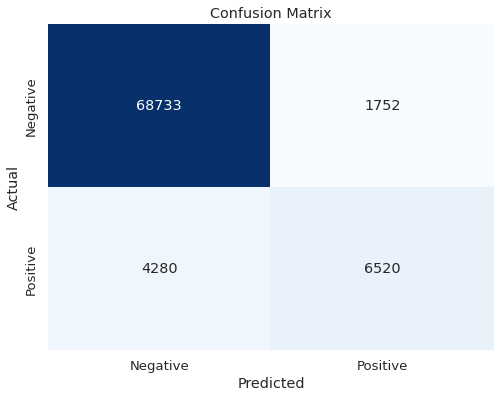

Accuracy: 0.9257919665374915
Precision: 0.7882011605415861
Recall: 0.6037037037037037
F1 Score: 0.6837248322147651


In [8]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [6]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/05_checkpoint4.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
GPU = 4

from models.text_heatmap_sigmoid import TextHeatmapSigmoidClassifier
from collections import OrderedDict
model = TextHeatmapSigmoidClassifier(gating=True, use_dropout=True)

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # remove `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.to(GPU)
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_text_ft = batch['left_text_emb']
        right_text_ft = batch['right_text_emb']
        left_heatmaps = batch['left_heatmap']
        right_heatmaps = batch['right_heatmap']
        labels = batch['label']
        
        left_heatmaps = left_heatmaps.unsqueeze(1).to(GPU)
        right_heatmaps = right_heatmaps.unsqueeze(1).to(GPU)
        left_text_ft = left_text_ft.squeeze(1).float().to(GPU)
        right_text_ft = right_text_ft.squeeze(1).float().to(GPU)
        label_tensor = labels.float().unsqueeze(1).to(GPU)
        
        outputs = model(left_heatmaps, right_heatmaps, left_text_ft, right_text_ft)
        # loss = criterion(outputs, label_tensor)
        preds = (outputs > 0.5).float()

        TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        acc = (TP + TN) / len(image_paths)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        # print(f'Batch prec:{prec}')
        # print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], outputs[i].item(), preds[i].item(), labels[i].item()])             

/work/adapting-CLIP-VGPs


100%|██████████| 813/813 [06:10<00:00,  2.19it/s]


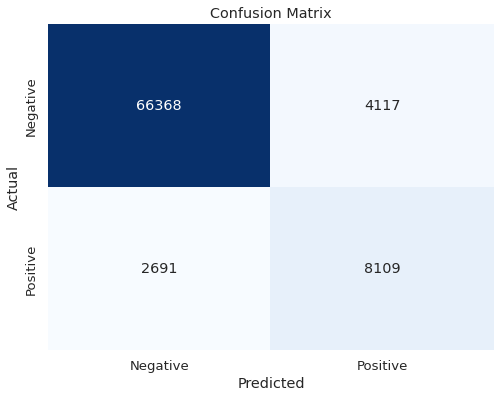

Accuracy: 0.9162453097127391
Precision: 0.6632586291509897
Recall: 0.7508333333333334
F1 Score: 0.7043342308694519


In [7]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [9]:
text_heatmap_pred = pred.copy()

# Text only

In [10]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm
from train_text_only import TextEmbClassifier

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/text_only/checkpoint22.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
GPU =1

from collections import OrderedDict
model = TextEmbClassifier()

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # add `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.to(GPU)
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test", text_only=True)
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_text_ft = batch['left_text_emb']
        right_text_ft = batch['right_text_emb']
        labels = batch['label']
        
        left_text_ft = left_text_ft.squeeze(1).to(GPU)
        right_text_ft = right_text_ft.squeeze(1).to(GPU)
        label_tensor = labels.float().unsqueeze(1).to(GPU)
        
        outputs = model(left_text_ft, right_text_ft)
        # loss = criterion(outputs, label_tensor)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        acc = (TP + TN) / len(image_paths)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        # print(f'Batch prec:{prec}')
        # print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], probs[i].item(), preds[i].item(), labels[i].item()])             

/work/adapting-CLIP-VGPs


100%|██████████| 813/813 [00:18<00:00, 44.51it/s]


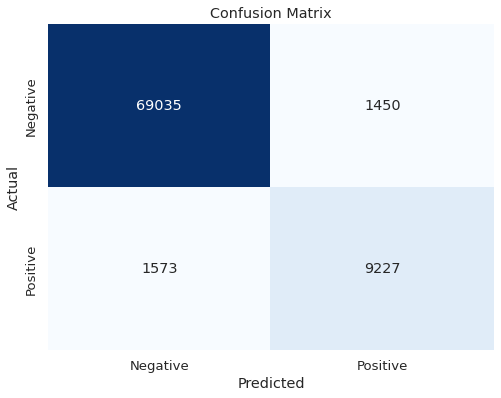

Accuracy: 0.962809866519038
Precision: 0.8641940620024351
Recall: 0.8543518518518518
F1 Score: 0.859244773478605


In [11]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [12]:
text_only_pred = pred.copy()

# 3. F1 score over cos sim

## Export test predictions

In [38]:
import pandas as pd

cos_sim_val_res = pd.read_csv('/work/adapting-CLIP-VGPs/test_text_hm.csv')
cos_sim_val_res.head()

,img_idx,phrases,text_sim,heatmap_sim,avgsim,pred,ytrue
0,1016887272,"['Several climbers', 'Seven climbers']",0.886846,0.931074,0.908960,True,True
1,1016887272,"['Several climbers', 'a rock face']",0.669547,0.151576,0.410561,False,False
2,1016887272,"['Several climbers', 'another man']",0.614288,0.332594,0.473441,False,False
3,1016887272,"['Several climbers', 'the rope']",0.594157,0.239266,0.416711,False,False
4,1016887272,"['the rock', 'Seven climbers']",0.587064,0.153814,0.370439,False,False


In [39]:
cos_sim_val_res.rename(columns={'pred': 'avg_sim_pred'}, inplace=True)
cos_sim_val_res.head()

,img_idx,phrases,text_sim,heatmap_sim,avgsim,avg_sim_pred,ytrue
0,1016887272,"['Several climbers', 'Seven climbers']",0.886846,0.931074,0.908960,True,True
1,1016887272,"['Several climbers', 'a rock face']",0.669547,0.151576,0.410561,False,False
2,1016887272,"['Several climbers', 'another man']",0.614288,0.332594,0.473441,False,False
3,1016887272,"['Several climbers', 'the rope']",0.594157,0.239266,0.416711,False,False
4,1016887272,"['the rock', 'Seven climbers']",0.587064,0.153814,0.370439,False,False


In [40]:
cos_sim_val_res['heatmap_only_pred'] = heatmap_only_pred
cos_sim_val_res['text_only_pred'] = text_only_pred
cos_sim_val_res['text_heatmap_pred'] = text_heatmap_pred
cos_sim_val_res.head()

,img_idx,phrases,text_sim,heatmap_sim,avgsim,avg_sim_pred,ytrue,heatmap_only_pred,text_only_pred,text_heatmap_pred
0,1016887272,"['Several climbers', 'Seven climbers']",0.886846,0.931074,0.908960,True,True,1.0,1.0,1.0
1,1016887272,"['Several climbers', 'a rock face']",0.669547,0.151576,0.410561,False,False,0.0,0.0,0.0
2,1016887272,"['Several climbers', 'another man']",0.614288,0.332594,0.473441,False,False,0.0,0.0,0.0
3,1016887272,"['Several climbers', 'the rope']",0.594157,0.239266,0.416711,False,False,0.0,0.0,0.0
4,1016887272,"['the rock', 'Seven climbers']",0.587064,0.153814,0.370439,False,False,0.0,0.0,0.0


In [41]:
over = cos_sim_val_res[cos_sim_val_res['heatmap_sim']>=0.1]
# over.head()
under = over[over['heatmap_sim']<0.2]
under.head()

,img_idx,phrases,text_sim,heatmap_sim,avgsim,avg_sim_pred,ytrue,heatmap_only_pred,text_only_pred,text_heatmap_pred
1,1016887272,"['Several climbers', 'a rock face']",0.669547,0.151576,0.410561,False,False,0.0,0.0,0.0
4,1016887272,"['the rock', 'Seven climbers']",0.587064,0.153814,0.370439,False,False,0.0,0.0,0.0
8,1016887272,"['the man', 'Seven climbers']",0.588484,0.189838,0.389161,False,False,0.0,0.0,0.0
15,1016887272,"['red', 'the rope']",0.552491,0.186929,0.369710,False,False,0.0,0.0,0.0
27,1016887272,"['red', 'a rock climbing wall']",0.548171,0.168028,0.358100,False,False,0.0,0.0,0.0


In [42]:
import numpy as np

data = {}
data['cos_sim'] = [x.round(2) for x in np.arange(start=0.1, stop=1.1, step=0.1)]

In [43]:
methods = ['text_only', 'heatmap_only', 'text_heatmap']
metrics = ['f1', 'prec', 'rec']
for method in methods:
    for metric in metrics:
        data[f'{method}_{metric}'] = []

data['true_count'] = []

for cos_sim in data['cos_sim']:
    cos_sim.round(2)
    over = cos_sim_val_res[cos_sim_val_res['heatmap_sim']>=cos_sim-0.1]
    data_in_range = over[over['heatmap_sim']<cos_sim]
    for method in methods:
        ytrue = data_in_range['ytrue']
        preds = data_in_range[f'{method}_pred']
        f1 = f1_score(ytrue, preds)*100
        prec = precision_score(ytrue, preds)*100
        rec = recall_score(ytrue, preds)*100
        data[f'{method}_f1'].append(f1.round(2))
        data[f'{method}_prec'].append(prec.round(2))
        data[f'{method}_rec'].append(rec.round(2))
    data['true_count'].append(sum(ytrue))

print(data)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'cos_sim': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'text_only_f1': [64.15, 54.14, 65.22, 74.33, 78.18, 77.11, 79.26, 83.63, 90.04, 93.72], 'text_only_prec': [58.62, 55.38, 69.54, 78.52, 83.2, 81.4, 81.66, 85.2, 89.07, 91.11], 'text_only_rec': [70.83, 52.94, 61.4, 70.57, 73.73, 73.26, 77.0, 82.12, 91.02, 96.47], 'heatmap_only_f1': [0.0, 0.0, 0.0, 0.0, 1.01, 9.33, 21.36, 33.54, 60.58, 87.42], 'heatmap_only_prec': [0.0, 0.0, 0.0, 0.0, 14.29, 42.86, 49.57, 54.6, 73.28, 84.75], 'heatmap_only_rec': [0.0, 0.0, 0.0, 0.0, 0.53, 5.23, 13.62, 24.2, 51.64, 90.25], 'text_heatmap_f1': [0.0, 0.0, 20.2, 15.51, 29.18, 40.23, 48.98, 57.53, 77.74, 90.29], 'text_heatmap_prec': [0.0, 0.0, 74.07, 62.22, 60.11, 65.27, 67.07, 71.22, 80.86, 86.86], 'text_heatmap_rec': [0.0, 0.0, 11.7, 8.86, 19.26, 29.07, 38.58, 48.25, 74.86, 94.01], 'true_count': [24, 68, 171, 316, 571, 860, 1278, 1913, 2963, 2636]}


In [44]:
import seaborn as sns

df = pd.DataFrame(data)
df.to_csv('test_all.csv', index=False)

## Read and visualize

In [45]:
import pandas as pd
data = pd.read_csv('/work/adapting-CLIP-VGPs/test_all.csv')
data

,cos_sim,text_only_f1,text_only_prec,text_only_rec,heatmap_only_f1,heatmap_only_prec,heatmap_only_rec,text_heatmap_f1,text_heatmap_prec,text_heatmap_rec,true_count
0,0.1,64.15,58.62,70.83,0.00,0.00,0.00,0.00,0.00,0.00,24
1,0.2,54.14,55.38,52.94,0.00,0.00,0.00,0.00,0.00,0.00,68
2,0.3,65.22,69.54,61.40,0.00,0.00,0.00,20.20,74.07,11.70,171
3,0.4,74.33,78.52,70.57,0.00,0.00,0.00,15.51,62.22,8.86,316
4,0.5,78.18,83.20,73.73,1.01,14.29,0.53,29.18,60.11,19.26,571
5,0.6,77.11,81.40,73.26,9.33,42.86,5.23,40.23,65.27,29.07,860
6,0.7,79.26,81.66,77.00,21.36,49.57,13.62,48.98,67.07,38.58,1278
7,0.8,83.63,85.20,82.12,33.54,54.60,24.20,57.53,71.22,48.25,1913
8,0.9,90.04,89.07,91.02,60.58,73.28,51.64,77.74,80.86,74.86,2963
9,1.0,93.72,91.11,96.47,87.42,84.75,90.25,90.29,86.86,94.01,2636


Text(0, 0.5, 'Average F1 score')

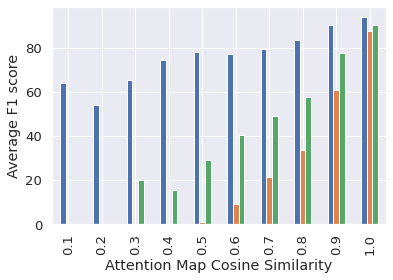

In [46]:
f1plot = data.plot(
    x='cos_sim',
    y=['text_only_f1', 'heatmap_only_f1', 'text_heatmap_f1'],
    kind='bar',
    stacked=False,
    legend=None,
)
f1plot.set_xlabel('Attention Map Cosine Similarity')
f1plot.set_ylabel('Average F1 score')
# f1plot.legend(['Attention map only', 'Text and map'])

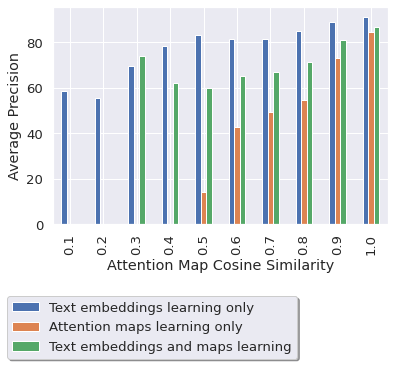

In [47]:
prec_plot = data.plot(
    x='cos_sim',
    y=['text_only_prec', 'heatmap_only_prec', 'text_heatmap_prec'],
    kind='bar',
    stacked=False
)
prec_plot.set_xlabel('Attention Map Cosine Similarity')
prec_plot.set_ylabel('Average Precision')
prec_plot.legend(['Text embeddings learning only', 'Attention maps learning only', 'Text embeddings and maps learning'], bbox_to_anchor=(0.75, -0.3),fancybox=True, shadow=True)

Text(0, 0.5, 'Average Recall')

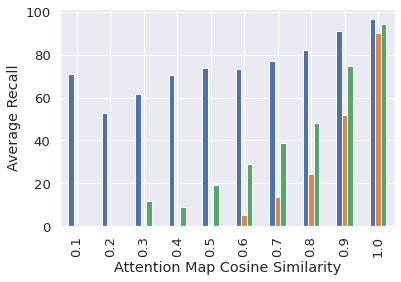

In [48]:
rec_plot = data.plot(
    x='cos_sim',
    y=['text_only_rec', 'heatmap_only_rec', 'text_heatmap_rec'],
    kind='bar',
    stacked=False,
    legend=None
)
rec_plot.set_xlabel('Attention Map Cosine Similarity')
rec_plot.set_ylabel('Average Recall')

# Scores over easy and hard VGP

In [49]:
def Jaccard_sim(x, y):
    phrase_set1 = set(x.split('+'))
    phrase_set2 = set(y.split('+'))

    intersect = len(phrase_set1.intersection(phrase_set2))
    union = len(phrase_set1.union(phrase_set2))
    return intersect/union

In [50]:
from tqdm import tqdm
import csv

test_path = '/work/adapting-CLIP-VGPs/data/flickr/phrases_data/phrase_pair_remove_trivial_match_test.csv'

phrases = []
scores = []
gt = []

with open(test_path, encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for i, row in tqdm(enumerate(reader)):
        phrase1 = row['phrase1']
        phrase2 = row['phrase2']
        label = row['ytrue']
        scores.append(Jaccard_sim(phrase1, phrase2))
        phrases.append([phrase1, phrase2])
        gt.append(row['ytrue']=='True')

0it [00:00, ?it/s]

81285it [00:00, 92396.79it/s] 


In [51]:
data = pd.read_csv('/work/adapting-CLIP-VGPs/test_text_hm.csv')
data.rename(columns={'pred': 'text_map_cosavg_pred'}, inplace=True)
data['text_cos_sim_pred'] = data.text_sim > 0.809
data['map_cos_sim_pred'] = data.heatmap_sim > 0.74
data['Jaccard_sim'] = scores
data['text_only_pred'] = text_only_pred
data['heatmap_only_pred'] = heatmap_only_pred
data['text_heatmap_pred'] = text_heatmap_pred
data['Jaccard_pred'] = np.array(scores)>0.0
data

,img_idx,phrases,text_sim,heatmap_sim,avgsim,text_map_cosavg_pred,ytrue,text_cos_sim_pred,map_cos_sim_pred,Jaccard_sim,text_only_pred,heatmap_only_pred,text_heatmap_pred,Jaccard_pred
0,1016887272,"['Several climbers', 'Seven climbers']",0.886846,0.931074,0.908960,True,True,True,True,0.333333,1.0,1.0,1.0,True
1,1016887272,"['Several climbers', 'a rock face']",0.669547,0.151576,0.410561,False,False,False,False,0.000000,0.0,0.0,0.0,False
2,1016887272,"['Several climbers', 'another man']",0.614288,0.332594,0.473441,False,False,False,False,0.000000,0.0,0.0,0.0,False
3,1016887272,"['Several climbers', 'the rope']",0.594157,0.239266,0.416711,False,False,False,False,0.000000,0.0,0.0,0.0,False
4,1016887272,"['the rock', 'Seven climbers']",0.587064,0.153814,0.370439,False,False,False,False,0.000000,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81280,1015118661,"['a man', 'the street']",0.778840,0.597029,0.687934,False,False,False,False,0.000000,0.0,0.0,0.0,False
81281,1015118661,"['A boy', 'A young boy']",0.940454,0.888069,0.914262,True,True,True,True,0.500000,1.0,1.0,1.0,True
81282,1015118661,"['A boy', 'the street']",0.765728,0.294031,0.529879,False,False,False,False,0.000000,0.0,0.0,0.0,False
81283,1015118661,"['a stony wall', 'A young boy']",0.691807,0.153298,0.422552,False,False,False,False,0.000000,0.0,0.0,0.0,False


In [52]:
easy = data[
    ((data.Jaccard_sim >= 0.25) & data.ytrue)
    | ((data.Jaccard_sim < 0.25) & (data.ytrue == False))
]
easy

,img_idx,phrases,text_sim,heatmap_sim,avgsim,text_map_cosavg_pred,ytrue,text_cos_sim_pred,map_cos_sim_pred,Jaccard_sim,text_only_pred,heatmap_only_pred,text_heatmap_pred,Jaccard_pred
0,1016887272,"['Several climbers', 'Seven climbers']",0.886846,0.931074,0.908960,True,True,True,True,0.333333,1.0,1.0,1.0,True
1,1016887272,"['Several climbers', 'a rock face']",0.669547,0.151576,0.410561,False,False,False,False,0.000000,0.0,0.0,0.0,False
2,1016887272,"['Several climbers', 'another man']",0.614288,0.332594,0.473441,False,False,False,False,0.000000,0.0,0.0,0.0,False
3,1016887272,"['Several climbers', 'the rope']",0.594157,0.239266,0.416711,False,False,False,False,0.000000,0.0,0.0,0.0,False
4,1016887272,"['the rock', 'Seven climbers']",0.587064,0.153814,0.370439,False,False,False,False,0.000000,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81280,1015118661,"['a man', 'the street']",0.778840,0.597029,0.687934,False,False,False,False,0.000000,0.0,0.0,0.0,False
81281,1015118661,"['A boy', 'A young boy']",0.940454,0.888069,0.914262,True,True,True,True,0.500000,1.0,1.0,1.0,True
81282,1015118661,"['A boy', 'the street']",0.765728,0.294031,0.529879,False,False,False,False,0.000000,0.0,0.0,0.0,False
81283,1015118661,"['a stony wall', 'A young boy']",0.691807,0.153298,0.422552,False,False,False,False,0.000000,0.0,0.0,0.0,False


In [53]:
hard = data[
    ((data.Jaccard_sim < 0.25) & data.ytrue)
    | ((data.Jaccard_sim >= 0.25) & (data.ytrue == False))
]
hard

,img_idx,phrases,text_sim,heatmap_sim,avgsim,text_map_cosavg_pred,ytrue,text_cos_sim_pred,map_cos_sim_pred,Jaccard_sim,text_only_pred,heatmap_only_pred,text_heatmap_pred,Jaccard_pred
5,1016887272,"['the rock', 'a rock face']",0.823491,0.777486,0.800489,True,False,True,True,0.50,0.0,1.0,1.0,True
19,1016887272,"['the line', 'the rope']",0.759768,0.659082,0.709425,True,True,False,False,0.00,1.0,0.0,0.0,False
20,1016887272,"['Several climbers', 'A group of people']",0.762660,0.578440,0.670550,False,True,False,False,0.00,1.0,0.0,0.0,False
30,1016887272,"['Several climbers', 'A group of people']",0.762660,0.578440,0.670550,False,True,False,False,0.00,1.0,0.0,0.0,False
43,1016887272,"['Several climbers', 'A collage of one person']",0.640140,0.440216,0.540178,False,True,False,False,0.00,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81141,5501340599,"['a stuffed animal', 'her teddy bear']",0.757123,0.870820,0.813971,True,True,False,True,0.00,1.0,0.0,0.0,False
81180,1015118661,"['Smiling boy', 'A young child']",0.782082,0.678251,0.730166,True,True,False,False,0.00,1.0,0.0,1.0,False
81227,1015118661,"['A little boy', 'A young child']",0.917640,0.954509,0.936075,True,True,True,True,0.00,1.0,1.0,1.0,False
81243,1015118661,"['a stone wall', 'a stone paved street']",0.752302,0.384022,0.568162,False,False,False,False,0.25,0.0,0.0,0.0,True


Text(0, 0.5, 'F1')

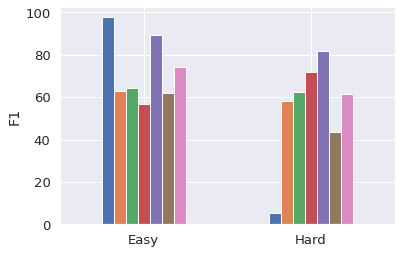

In [54]:
f1_scores = {}
methods = ['Jaccard', 'text_cos_sim', 'map_cos_sim', 'text_map_cosavg', 'text_only', 'heatmap_only', 'text_heatmap']
method_labels = ['Word overlap', 'Text embedding similarity', 'Attention map similarity', 'Text+map similarity average', 'Text embeddings learning only', 'Attention maps learning only', 'Text embeddings + Attention maps learning']
x = ['Easy', 'Hard']

for method in methods:
    f1_scores[method] = []

for table in [easy, hard]:
    for method in methods:
        f1 = f1_score(table.ytrue, table[f'{method}_pred'])*100
        f1_scores[method].append(f1.round(2))

# Plot
f1_data = pd.DataFrame(f1_scores)
f1plot = f1_data.plot(
    kind='bar',
    stacked=False,
    legend=None
)
f1plot.set_xticklabels(x, rotation=360)
f1plot.set_ylabel('F1')
# f1plot.legend(
#     method_labels, loc='upper center', 
#     bbox_to_anchor=(0.5, -0.1),
#     fancybox=True, shadow=True, ncol=2
# )

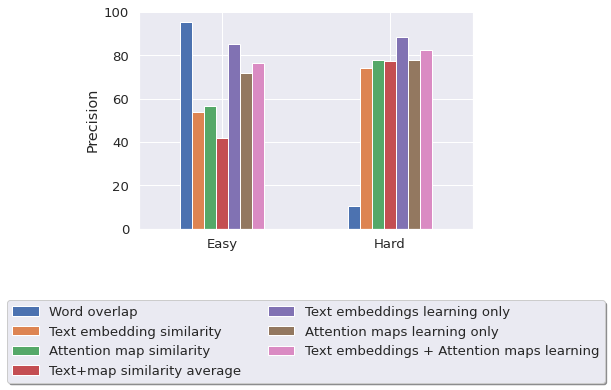

In [55]:
prec_scores = {}

for method in methods:
    prec_scores[method] = []

for table in [easy, hard]:
    for method in methods:
        prec = precision_score(table.ytrue, table[f'{method}_pred'])*100
        prec_scores[method].append(prec.round(2))

# Plot
prec_data = pd.DataFrame(prec_scores)
prec_plot = prec_data.plot(
    kind='bar',
    stacked=False
)
prec_plot.set_xticklabels(x, rotation=360)
prec_plot.set_ylabel('Precision')
prec_plot.legend(
    method_labels, loc='upper center', 
    bbox_to_anchor=(0.5, -0.3),
    fancybox=True, shadow=True, ncol=2
)

Text(0, 0.5, 'Recall')

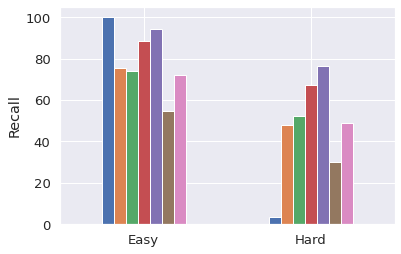

In [56]:
rec_scores = {}

for method in methods:
    rec_scores[method] = []

for table in [easy, hard]:
    for method in methods:
        rec = recall_score(table.ytrue, table[f'{method}_pred'])*100
        rec_scores[method].append(rec.round(2))

# Plot
rec_data = pd.DataFrame(rec_scores)
rec_plot = rec_data.plot(
    kind='bar',
    stacked=False,
    legend=None
)
rec_plot.set_xticklabels(x, rotation=360)
rec_plot.set_ylabel('Recall')

# 4. Visualize some identification

In [57]:
easy

,img_idx,phrases,text_sim,heatmap_sim,avgsim,text_map_cosavg_pred,ytrue,text_cos_sim_pred,map_cos_sim_pred,Jaccard_sim,text_only_pred,heatmap_only_pred,text_heatmap_pred,Jaccard_pred
0,1016887272,"['Several climbers', 'Seven climbers']",0.886846,0.931074,0.908960,True,True,True,True,0.333333,1.0,1.0,1.0,True
1,1016887272,"['Several climbers', 'a rock face']",0.669547,0.151576,0.410561,False,False,False,False,0.000000,0.0,0.0,0.0,False
2,1016887272,"['Several climbers', 'another man']",0.614288,0.332594,0.473441,False,False,False,False,0.000000,0.0,0.0,0.0,False
3,1016887272,"['Several climbers', 'the rope']",0.594157,0.239266,0.416711,False,False,False,False,0.000000,0.0,0.0,0.0,False
4,1016887272,"['the rock', 'Seven climbers']",0.587064,0.153814,0.370439,False,False,False,False,0.000000,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81280,1015118661,"['a man', 'the street']",0.778840,0.597029,0.687934,False,False,False,False,0.000000,0.0,0.0,0.0,False
81281,1015118661,"['A boy', 'A young boy']",0.940454,0.888069,0.914262,True,True,True,True,0.500000,1.0,1.0,1.0,True
81282,1015118661,"['A boy', 'the street']",0.765728,0.294031,0.529879,False,False,False,False,0.000000,0.0,0.0,0.0,False
81283,1015118661,"['a stony wall', 'A young boy']",0.691807,0.153298,0.422552,False,False,False,False,0.000000,0.0,0.0,0.0,False
